In [1]:
import sys
from os import path
_up_one = path.abspath('../')
if _up_one not in sys.path:
    sys.path.insert(1, _up_one)

# Third-party
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from lg_barycentric import LocalGroupBarycentric

In [31]:
nearby = ascii.read('../data/NearbyGalaxies_wmore.dat', delimiter=',')

In [32]:
c = coord.SkyCoord(ra=nearby['RA'],
                   dec=nearby['Dec'],
                   distance=coord.Distance(distmod=nearby['distmod']),
                   unit=(u.hourangle, u.deg))

In [33]:
c_barycen = c.transform_to(LocalGroupBarycentric(mw_mass=1E12*u.Msun,
                                                 m31_mass=2.5E12*u.Msun))

In [57]:
hasHI = nearby['MHI']>0
logMoLV = (np.log10(nearby['MHI']) - nearby['logLV'])

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


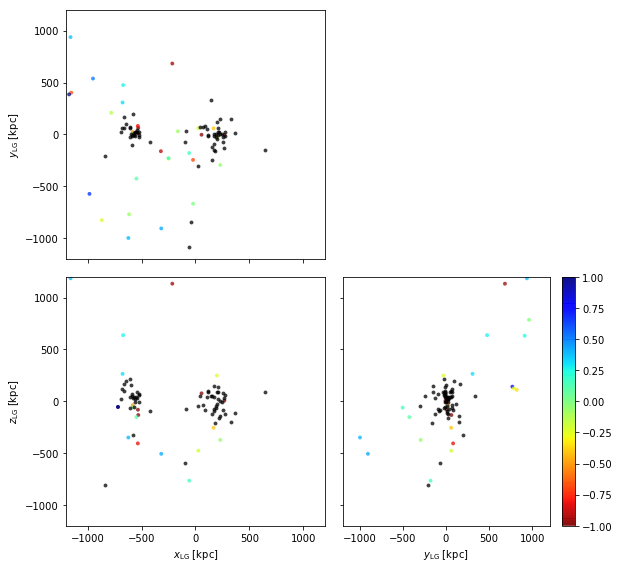

In [61]:
#style = dict(marker='.', linestyle='none', alpha=0.65)
style = dict(marker='o', alpha=.75, s=15, lw=0)

fig, axes = plt.subplots(2, 2, figsize=(8.75,8), sharex=True, sharey=True)

for i in range(2):
    if i == 0:
        cart = c_barycen.cartesian[hasHI]
        style['c'] = logMoLV[hasHI]
        style['cmap'] = 'jet_r'
        style['vmin'] = -1
        style['vmax'] = 1
    elif i == 1:
        cart = c_barycen.cartesian[~hasHI]
        style['c'] = 'k'
    else:
        assert False
        
    axes[0,0].scatter(cart.xyz[0],
                   cart.xyz[1],
                   **style)
    axes[1,0].scatter(cart.xyz[0],
                   cart.xyz[2],
                   **style)
    cm = axes[1,1].scatter(cart.xyz[1],
                   cart.xyz[2],
                   **style)
    if i==0:
        plt.colorbar(cm)



axes[0,0].set_xlim(-1200, 1200)
axes[0,0].set_ylim(-1200, 1200)

axes[0,0].set_ylabel(r'$y_{\rm LG}$ [kpc]')
axes[1,0].set_ylabel(r'$z_{\rm LG}$ [kpc]')
axes[1,0].set_xlabel(r'$x_{\rm LG}$ [kpc]')
axes[1,1].set_xlabel(r'$y_{\rm LG}$ [kpc]')

axes[0,0].xaxis.set_ticks(np.arange(-1000, 1000+1, 500))
axes[0,0].yaxis.set_ticks(axes[0,0].get_xticks())

axes[0,1].set_visible(False)

fig.tight_layout()

# Flattening 

In [90]:
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation

In [103]:
def barycen_to_flattened(c, flattening=0):
    newx = c.cartesian.x
    newy = c.cartesian.y * (1-flattening)
    newz = c.cartesian.z * (1-flattening)
    return CartesianRepresentation(newx, newy, newz).represent_as(SphericalRepresentation)

assert np.all(barycen_to_flattened(c_barycen).distance == c_barycen.spherical.distance)
assert not np.any(barycen_to_flattened(c_barycen, .5 ).distance == c_barycen.spherical.distance)

# Optimization 

In [6]:
import emcee

In [7]:
MINF = -np.inf

def lpro(rad, flat):
    if not 0 < rad < 1000:
        return MINF
    if not 0 < flat < .9:
        return MINF
    return 0

def lnprob(params):
    rad, flat = params
    
    lpri = lpri(rad, flat)
    if lpri == MINF:
        return MINF
    
    d = barycen_to_flattened(c_barycen, flat).distance
    
    lnprob = d < rad
    
    return lpri + lnprob
    
    
    

sampler = emcee.EnsembleSampler(20, 2, lnprob)